In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import joblib


df = pd.read_excel("/Users/zhiranbai/Downloads/补充混合+板换+冷机水流量.xlsx")


# Assuming df is your DataFrame

# Step 1: Filter out rows where '冷塔频率' or '冷塔功率' have NaNs
filtered_df = df.dropna(subset=['冷塔频率', '冷塔功率'])


In [2]:
#冷量



def summer_coolDemand(冷冻水进水流量, 冷机冷冻水进水温度, 冷机冷冻水出水温度):
    冷冻水进水流量 = float(冷冻水进水流量)
    冷机冷冻水进水温度 = float(冷机冷冻水进水温度)
    冷机冷冻水出水温度 = float(冷机冷冻水出水温度)
    water_heatCapcity=4.186*1000/3600
    return 冷冻水进水流量 * water_heatCapcity * (冷机冷冻水进水温度 - 冷机冷冻水出水温度)

# Function for calculating winter cooling demand
def winter_coolDemand(板换冷冻水进水温度, 板换冷冻水出水温度, 冷冻水流量):
    板换冷冻水进水温度 = float(板换冷冻水进水温度)
    板换冷冻水出水温度 = float(板换冷冻水出水温度)
    冷冻水流量 = float(冷冻水流量)
    water_heatCapcity=4.186*1000/3600
    return (板换冷冻水进水温度 - 板换冷冻水出水温度) * 冷冻水流量 * water_heatCapcity

# Function for calculating cooling demand for an intermediate scenario
def intermediate_coolDemand(板换冷冻水进水温度, 冷机冷冻水出水温度, 冷冻水进水流量):
    板换冷冻水进水温度 = float(板换冷冻水进水温度)
    冷机冷冻水出水温度 = float(冷机冷冻水出水温度)
    冷冻水进水流量 = float(冷冻水进水流量)
    water_heatCapcity=4.186*1000/3600
    return (板换冷冻水进水温度 - 冷机冷冻水出水温度) * 冷冻水进水流量 * water_heatCapcity


def calculate_coolDemand(row):
    # Extract the run mode from the row
    runMode = row['运行模式']
    
    # Calculate cooling demand based on the mode
    if runMode == '冷机模式':
        return summer_coolDemand(row['冷冻水流量'], row['冷机冷冻回水温度'], row['冷机冷冻出水温度'])
    elif runMode == '混合模式' and row['冷机功率'] !=0:
        return intermediate_coolDemand(row['板换冷冻回水温度'],row['冷机冷冻出水温度'], row['冷冻水流量'])
    elif runMode == '板换模式' or (runMode == '混合模式' and row['冷机功率'] ==0 ):
        return winter_coolDemand(row['板换冷冻回水温度'], row['板换冷冻出水温度'], row['冷冻水流量'])
    else:
        return None  # or an appropriate default/fallback value

In [3]:
#建立总功耗，频率表
#运行模式：冷量： 功率：（塔数，频率）
tower_dictionary={}

for index, row in filtered_df.iterrows():
    runMode = row['运行模式']
    if pd.notna(runMode):
        frequency=row['冷塔频率']
        if '/' in str(frequency):
            coolDemand=calculate_coolDemand(row)
            power= row['冷塔功率']
            
            powers = power.split('/')
            frequencies = frequency.split('/')
            total_power = sum(float(p) for p in powers)
            towerNumber = len(frequencies) 
            if runMode not in tower_dictionary:
                tower_dictionary[runMode] = {}
            if coolDemand not in tower_dictionary[runMode]:
                tower_dictionary[runMode][coolDemand] = {}
            if total_power not in tower_dictionary[runMode][coolDemand]:
                tower_dictionary[runMode][coolDemand][total_power] = []
            if (towerNumber, frequency) not in tower_dictionary[runMode][coolDemand][total_power]:
                tower_dictionary[runMode][coolDemand][total_power].append((towerNumber, frequency))
#             else:
                
#                 tower_dictionary[runMode][coolDemand][power].append((1, frequency))  # Using 1 as the default tower number


In [4]:
tower_dictionary

{'板换模式': {3935.1062025858555: {13.4: [(3, '1.1/30.6/30.9')],
   14.4: [(3, '1.1/30.6/30.9')],
   16.0: [(3, '41.2/41.2/41.4')],
   10.7: [(3, '37.3/0.7/37.4')],
   11.3: [(3, '44.8/0.7/45')]},
  3795.6554999999985: {12.5: [(4, '39.8/0.4/0.2/39.7')],
   8.8: [(4, '39.8/0.4/0.2/39.7')],
   10.8: [(4, '39.8/0.4/0.2/39.7')]},
  3935.1062025858573: {13.4: [(3, '1.1/30.6/30.9')],
   20.4: [(3, '1.1/43.9/44.2')],
   20.7: [(3, '1.1/43.9/44.2')],
   21.2: [(3, '31.6/31.4/31.8')],
   24.5: [(3, '41.2/41.2/41.4')],
   16.0: [(3, '41.2/41.2/41.4')],
   11.1: [(3, '42.1/0.7/42.1')]},
  3727.633: {12.9: [(4, '39.8/0.4/0.2/40.3')],
   10.9: [(4, '39.8/0.4/0.2/40.3')]},
  3632.4015: {13.4: [(4, '41.8/0.4/0.2/41.7')],
   11.4: [(4, '41.8/0.4/0.2/41.7')]},
  4031.0844026489262: {13.4: [(3, '1.1/30.5/31'),
    (3, '1.1/32.1/32.7'),
    (3, '1.1/32.4/32.9')],
   16.0: [(3, '41.2/41.2/41.4')],
   5.1: [(3, '35.7/0.8/35.9')],
   11.3: [(3, '45.2/0.7/46.3')]},
  3583.2159999999976: {13.4: [(4, '30.4/0.4/0.2

In [5]:
#训练冷却塔模型

# Step 2: Extract X and Y from the filtered DataFrame
X = filtered_df[['冷却水流量', '室外湿球', '冷塔回水温度', '冷塔出水温度']].values
Y = filtered_df[['冷塔频率', '冷塔功率']].values



# Placeholder lists for single and multiple values, also for X
Y_single = []
Y_multiple = []
X_single = []
X_multiple = []

# Iterate through Y and categorize, also keeping track of the corresponding X
for i, y in enumerate(Y):
    # Check each column in the row for '/'
    multi_value_row = any('/' in str(val) for val in y)
    
    # If any column contains '/', it's a multiple value row
    if multi_value_row:
        # Split values by '/' and convert them to floats, then store Y
        Y_multiple.append([list(map(float, val.split('/'))) for val in y])
        # Store the corresponding X
        X_multiple.append(X[i])
    else:
        # Convert single string values to float and store Y
        Y_single.append(y.astype(float))
        # Store the corresponding X
        X_single.append(X[i])

# Convert to numpy arrays for consistency and further processing
Y_single = np.array(Y_single)
Y_multiple = np.array(Y_multiple, dtype=object)
X_single = np.array(X_single)
X_multiple = np.array(X_multiple)

single_tower_X=[]
single_tower_Y=[]
for y_record, x_record in zip(Y_multiple, X_multiple):
 # Extract both lists
    freq_list, pow_list = y_record  # Assuming y_record only has two elements

    # Check if both lists have the same length
    if len(freq_list) == len(pow_list):
        # Iterate through each index since the lengths are the same
        for i in range(len(freq_list)):
            # Combine the corresponding elements of both lists into a single list
            combined_y = [freq_list[i], pow_list[i]]
            # Append the combined list to single_tower_Y
            single_tower_Y.append(combined_y)
            # Append the corresponding x_record to single_tower_X
            single_tower_X.append(x_record)
    
    
#值全的，分开数值正常训练（1机1训） ；总值对总值 多对一 暂不考虑


# Normalize the data
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(single_tower_X)
Y_scaled = scaler_Y.fit_transform(single_tower_Y)

joblib.dump(scaler_X, '/Users/zhiranbai/Downloads/tower_scaler_X.pkl')
joblib.dump(scaler_Y, '/Users/zhiranbai/Downloads/tower_scaler_Y.pkl')
# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=42)

# Convert arrays to PyTorch tensors
X_train_torch = torch.tensor(X_train.astype(np.float32))
Y_train_torch = torch.tensor(Y_train.astype(np.float32))
X_test_torch = torch.tensor(X_test.astype(np.float32))
Y_test_torch = torch.tensor(Y_test.astype(np.float32))

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_torch, Y_train_torch)
test_dataset = TensorDataset(X_test_torch, Y_test_torch)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)



import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 8)
        self.fc7 = nn.Linear(8, 2)

        # Initialize weights using He initialization suited for ReLU
        init.kaiming_normal_(self.fc1.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.fc2.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.fc3.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.fc4.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.fc5.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.fc6.weight, mode='fan_out', nonlinearity='relu')
        # For the final layer, we use a general initialization as it does not use ReLU
        init.xavier_normal_(self.fc7.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        output = self.fc7(x)  # No activation function here, assuming a regression task
        
       
        return output
        

model = Net()
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
for epoch in range(400):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

model.eval()  # Set the model to evaluation mode
total_loss = 0
num_batches = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches
print(f'Average Loss on the Test Set: {average_loss}')

torch.save(model.state_dict(), '/Users/zhiranbai/Downloads/tower_model_weights.pth')

Net(
  (fc1): Linear(in_features=4, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=16, bias=True)
  (fc6): Linear(in_features=16, out_features=8, bias=True)
  (fc7): Linear(in_features=8, out_features=2, bias=True)
)
Epoch 1, Loss: 0.3719009459018707
Epoch 2, Loss: 0.26912739872932434
Epoch 3, Loss: 0.21257808804512024
Epoch 4, Loss: 0.14924423396587372
Epoch 5, Loss: 0.1253194957971573
Epoch 6, Loss: 0.06402911245822906
Epoch 7, Loss: 0.10776391625404358
Epoch 8, Loss: 0.05239647254347801
Epoch 9, Loss: 0.05454490706324577
Epoch 10, Loss: 0.08797942101955414
Epoch 11, Loss: 0.11510185897350311
Epoch 12, Loss: 0.0710873082280159
Epoch 13, Loss: 0.026183070614933968
Epoch 14, Loss: 0.010836510919034481
Epoch 15, Loss: 0.07667060196399689
Epoch 16, Loss: 0.034682177007198334
Epoch 

Epoch 212, Loss: 0.005587807856500149
Epoch 213, Loss: 0.052864108234643936
Epoch 214, Loss: 0.029908351600170135
Epoch 215, Loss: 0.038157545030117035
Epoch 216, Loss: 0.03657415509223938
Epoch 217, Loss: 0.026010669767856598
Epoch 218, Loss: 0.009077632799744606
Epoch 219, Loss: 0.04897807538509369
Epoch 220, Loss: 0.01633647084236145
Epoch 221, Loss: 0.022338617593050003
Epoch 222, Loss: 0.06350722908973694
Epoch 223, Loss: 0.03185708820819855
Epoch 224, Loss: 0.057775601744651794
Epoch 225, Loss: 0.0273029375821352
Epoch 226, Loss: 0.050274014472961426
Epoch 227, Loss: 0.039438456296920776
Epoch 228, Loss: 0.008625791408121586
Epoch 229, Loss: 0.0074531505815684795
Epoch 230, Loss: 0.035537656396627426
Epoch 231, Loss: 0.019106227904558182
Epoch 232, Loss: 0.017141681164503098
Epoch 233, Loss: 0.046888772398233414
Epoch 234, Loss: 0.017101984471082687
Epoch 235, Loss: 0.018873754888772964
Epoch 236, Loss: 0.028106337413191795
Epoch 237, Loss: 0.03666671738028526
Epoch 238, Loss: 0.

Average Loss on the Test Set: 0.031694717705249786


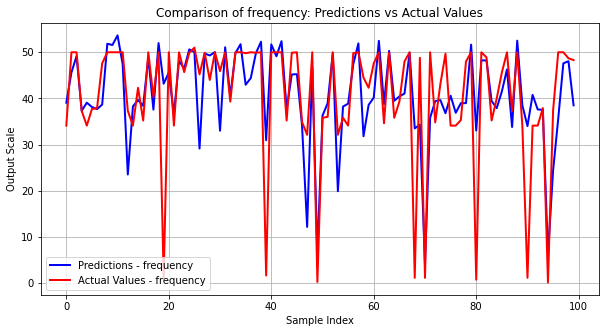

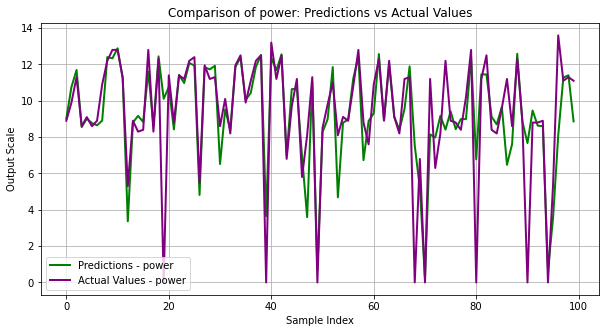

Prediction accuracy within a 20.0% threshold: 78.96%


In [6]:
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Assuming you have 'Net' class and data loaders already set up as per your code.

# Create an instance of the model and load weights
model = Net()
model.load_state_dict(torch.load('/Users/zhiranbai/Downloads/tower_model_weights.pth'))
model.eval()

# DataLoader for new or test data
# Assuming 'test_loader' is already defined

# Initialize the scaler for Y (assuming you have saved it after fitting)
# If scaler_Y was not saved, you must fit it again with training targets before this step
import joblib

scaler_Y = joblib.load('/Users/zhiranbai/Downloads/tower_scaler_Y.pkl')  # Make sure to save your scaler after fitting

# Predict and scale back
total_loss = 0
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        # Scale back the predictions
        outputs_np = outputs.numpy()  # Convert to NumPy array if not already
        outputs_scaled_back = scaler_Y.inverse_transform(outputs_np)
        
        targets_np = targets.numpy()
        targets_scaled_back = scaler_Y.inverse_transform(targets_np)

        # Optional: Calculate loss for evaluation
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        # Store predictions and actuals for further analysis or use
        predictions.append(outputs_scaled_back)
        actuals.append(targets_scaled_back)

# Calculate and print average loss if needed
num_batches = len(test_loader)
average_loss = total_loss / num_batches
print(f'Average Loss on the Test Set: {average_loss}')
predictions[0]

predictions_first_component = [item[0] for sublist in predictions for item in sublist]
predictions_second_component = [item[1] for sublist in predictions for item in sublist]
actuals_first_component = [item[0] for sublist in actuals for item in sublist]
actuals_second_component = [item[1] for sublist in actuals for item in sublist]

# Plotting the first component
plt.figure(figsize=(10, 5))
plt.plot(predictions_first_component[0:100], label='Predictions - frequency', color='blue', linewidth=2)
plt.plot(actuals_first_component[0:100], label='Actual Values - frequency', color='red', linewidth=2)
plt.title('Comparison of frequency: Predictions vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Output Scale')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the second component
plt.figure(figsize=(10, 5))
plt.plot(predictions_second_component[0:100], label='Predictions - power', color='green', linewidth=2)
plt.plot(actuals_second_component[0:100], label='Actual Values - power', color='purple', linewidth=2)
plt.title('Comparison of power: Predictions vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Output Scale')
plt.legend()
plt.grid(True)
plt.show()

threshold = 0.20  # This means predictions within 10% of the actual values are considered accurate

# Calculate the percentage difference and check if within threshold
accurate_predictions = np.abs(np.array(predictions_first_component) - np.array(actuals_first_component)) <= threshold * np.abs(np.array(actuals_first_component))
accuracy = np.mean(accurate_predictions) * 100  # Convert fraction of accurate predictions to percentage

print(f'Prediction accuracy within a {threshold*100}% threshold: {accuracy:.2f}%')
